# Tutorial 34: Comparing Covariance Estimators Methods

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4036%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.9483%,-1.1954%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7540%,-0.1730%,0.2409%,1.3734%,-1.0857%
2016-01-06,-11.4864%,-1.5879%,0.2411%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5866%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5647%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9034%,-2.9145%
2016-01-07,-5.1389%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8855%,-4.6058%,-2.5394%,...,-2.2066%,-3.0309%,-1.0411%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2737%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5707%,-1.6403%,-1.7642%,-0.1649%,...,-0.1538%,-1.1366%,-0.7308%,-0.1449%,0.0895%,-3.3839%,-0.1117%,-1.1386%,-0.9720%,-1.1254%
2016-01-11,-4.3384%,0.1692%,-1.6851%,-1.0215%,0.0914%,-1.1791%,0.5674%,0.5288%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1450%,1.2224%,1.4570%,0.5367%,-0.4608%,0.5800%,-1.9919%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that minimizes Variance.

| 방법       | 설명                                                                                   |
|------------|----------------------------------------------------------------------------------------|
| hist       | 역사적 방법: 역사적 데이터를 사용하여 공분산 행렬을 추정합니다.                        |
| ledoit     | Ledoit-Wolf 수축: 표본 공분산 행렬에 수축 추정기를 적용하여 추정 정확도를 개선합니다.   |
| oas        | Oracle Approximating Shrinkage: 작은 샘플 크기에 특히 효과적인 또 다른 수축 추정기입니다. |
| shrunk     | 수축: 공분산 행렬에 대한 일반적인 수축 추정기입니다.                                    |
| gl         | Graphical Lasso: Lasso 정규화를 사용하여 희소 역공분산 행렬을 추정합니다.                |
| ewma1      | 지수 가중 이동 평균 1: 최근 관측값에 더 많은 가중치를 부여하여 공분산을 추정합니다.      |
| ewma2      | 지수 가중 이동 평균 2: ewma1과 유사하지만 가중치 체계에 다른 감쇠 계수를 사용합니다.      |
| jlogo      | Jorion의 글로벌 최소 분산: 표본 공분산 행렬의 추정 오류를 고려하는 견고한 추정기입니다.  |
| fixed      | 고정: 미리 정해진 고정 공분산 행렬을 사용합니다.                                         |
| spectral   | 스펙트럴: 스펙트럴 분해 방법을 사용하여 공분산 행렬을 추정합니다.                       |
| shrink     | 수축: Ledoit-Wolf와 유사하지만 다른 수축 대상을 사용합니다.                               |
| gerber1    | Gerber1: 공분산 행렬 추정을 위한 Gerber의 첫 번째 방법을 사용하여 견고한 통계를 중시합니다. |
| gerber2    | Gerber2: Gerber의 두 번째 방법을 사용하여 기본 데이터에 대한 다른 가정을 포함합니다.     |


In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_covs = ['hist', 'ledoit', 'oas', 'shrunk', 'gl', 'ewma1',
               'ewma2','jlogo', 'fixed', 'spectral', 'shrink',
               'gerber1', 'gerber2']

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_s = pd.DataFrame([])

for i in method_covs:
    port.assets_stats(method_mu=method_mu, method_cov=i)
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = method_covs

You must convert self.cov to a positive definite matrix


In [4]:
display(w_s.style.format("{:.2%}").background_gradient(cmap='YlGn'))

,hist,ledoit,oas,shrunk,gl,ewma1,ewma2,jlogo,fixed,spectral,shrink,gerber1,gerber2
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.00%
BA,0.00%,0.00%,0.00%,0.23%,1.21%,7.07%,7.07%,2.81%,0.00%,0.00%,0.00%,1.14%,0.04%
BAX,5.24%,5.33%,5.29%,5.55%,6.31%,3.26%,3.26%,8.69%,4.05%,0.00%,3.16%,5.64%,6.39%
BMY,4.39%,4.45%,4.43%,4.64%,4.04%,8.14%,8.14%,5.16%,2.00%,0.00%,3.82%,2.96%,2.40%
CMCSA,2.13%,2.34%,2.25%,2.94%,4.08%,5.81%,5.81%,2.43%,1.10%,0.00%,1.10%,3.89%,3.79%
CNP,6.99%,7.10%,7.06%,7.36%,9.50%,4.25%,4.25%,6.58%,7.37%,0.00%,4.82%,7.78%,7.64%
CPB,3.23%,3.39%,3.32%,3.91%,4.63%,5.26%,5.26%,6.03%,1.68%,0.00%,1.78%,2.40%,0.45%
DE,0.07%,0.21%,0.16%,0.59%,0.11%,4.22%,4.22%,1.08%,0.00%,0.00%,0.00%,0.43%,0.00%
HPQ,0.00%,0.00%,0.00%,0.00%,0.00%,2.86%,2.86%,0.16%,0.00%,0.00%,0.00%,0.00%,0.00%
JCI,2.84%,2.94%,2.90%,3.21%,3.67%,3.80%,3.80%,4.70%,1.52%,0.00%,2.27%,2.07%,1.37%


<Axes: >

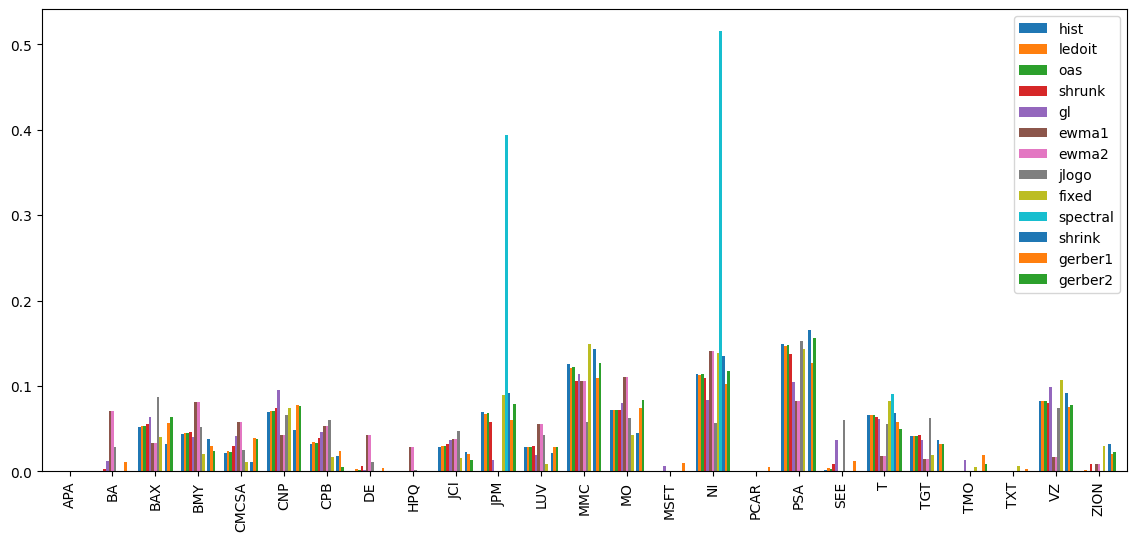

In [5]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio
fig, ax = plt.subplots(figsize=(14,6))

w_s.plot.bar(ax=ax, width=0.8)

### 2.2 Calculating the portfolio that maximizes Sharpe ratio.

In [7]:
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe

w_s = pd.DataFrame([])

for i in method_covs:
    port.assets_stats(method_mu=method_mu, method_cov=i)
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = method_covs

You must convert self.cov to a positive definite matrix


In [8]:
display(w_s.style.format("{:.2%}").background_gradient(cmap='YlGn'))

,hist,ledoit,oas,shrunk,gl,ewma1,ewma2,jlogo,fixed,spectral,shrink,gerber1,gerber2
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BA,6.16%,6.30%,6.24%,6.72%,4.33%,8.81%,8.81%,10.43%,4.07%,0.00%,4.86%,6.73%,6.74%
BAX,11.50%,11.61%,11.57%,11.47%,10.41%,7.36%,7.36%,13.24%,10.43%,0.00%,10.62%,10.20%,10.14%
BMY,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CMCSA,0.00%,0.00%,0.00%,0.00%,3.32%,0.19%,0.19%,0.00%,0.00%,0.00%,0.00%,0.84%,0.00%
CNP,8.48%,8.58%,8.54%,8.81%,11.76%,6.34%,6.34%,12.24%,6.55%,0.00%,4.79%,8.60%,8.27%
CPB,0.00%,0.00%,0.00%,0.00%,1.22%,0.05%,0.05%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
DE,3.82%,4.04%,3.95%,4.70%,3.10%,4.31%,4.31%,6.99%,2.75%,0.00%,2.87%,5.16%,4.07%
HPQ,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
JCI,0.00%,0.00%,0.00%,0.00%,0.49%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


<Axes: >

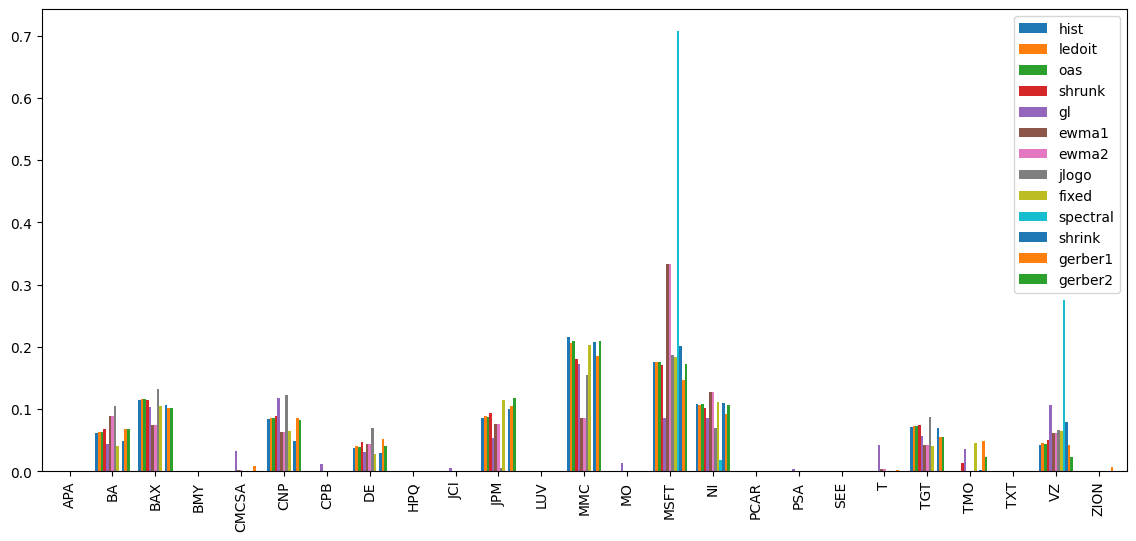

In [9]:
# Plotting a comparison of assets weights for each portfolio
ax, fig = plt.subplots(figsize=(14,6))

w_s.plot.bar(ax=fig, width=0.8)